# Verifying Kinetics Models: Part 2 - Writing Tests

Writing verification tests for kinetics models requires having insights as to the dynamic behavior expected of model variables. This discussion focuses on the concentration of molecules (floating species in ``tellurium``).

In [1]:
import numpy as np
import tellurium as te
from teUtils.named_timeseries import NamedTimeseries, TIME
from teUtils.timeseries_plotter import TimeseriesPlotter
plotter = TimeseriesPlotter()


## Lecture

### Expected Behavior of Model Variables
Our starting point is a framework for describing the expected behavior of model variables. This is best illustrated by example. Consider the model below that you used in the breakout.

In [2]:
def runModel(model, is_plot=True):
    """
    Runs and plots the model.
    
    Parameters
    ----------
    model: str
        An antimony model
        
    Returns
    -------
    NamedTimeseries of simulation results
    """
    rr = te.loada(model)
    data = rr.simulate(0, 4, 30)
    ts = NamedTimeseries(named_array=data)
    if is_plot:
        plotter.plotTimeSingle(ts, num_row=2, figsize=(12, 10))
    return ts

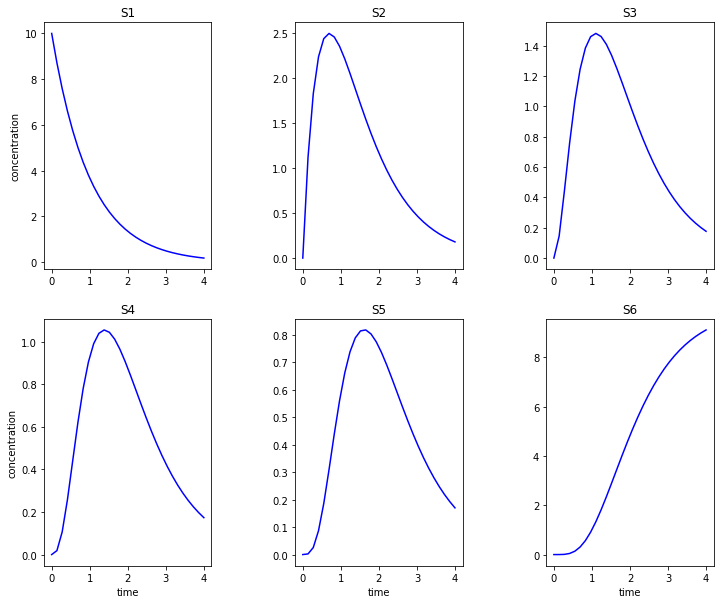

In [3]:
true_model = '''
        # Reactions   
        J1: S1 -> S2; k1*S1
        J2: S2 -> S3; k2*S2
        J3: S3 -> S4; k3*S3
        J4: S4 -> S5; k4*S4
        J5: S5 -> S6; k5*S5;
        # Species initializations     
        S1 = 10;
        k1 = 1; k2 = 2; k3 = 3; k4 = 4; k5 = 5;
        S1 = 10; S2 = 0; S3 = 0; S4 = 0; S5 = 0; S6 = 0;
        '''
ts0 = runModel(true_model)

Here are some observations about the dynamical behavior of this linear pipeline:
1. S1 is monotone deccreasing
1. S6 is monotone increasing
1. S2-S5 are not monotone.
1. The time at which $S_i$ peaks is less than the time at which $S_{i+1}$ peaks.

Let's see what happens if we had an error in our model.

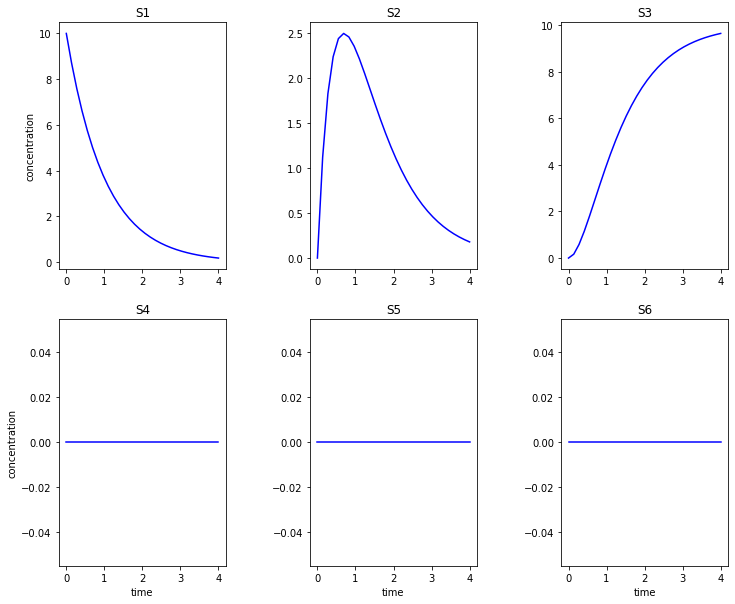

In [4]:
# Incorrect model - forgot J3
bad_model1 = '''
        # Reactions   
        J1: S1 -> S2; k1*S1
        J2: S2 -> S3; k2*S2
        J4: S4 -> S5; k4*S4
        J5: S5 -> S6; k5*S5;
        # Species initializations     
        S1 = 10;
        k1 = 1; k2 = 2; k3 = 3; k4 = 4; k5 = 5;
        S1 = 10; S2 = 0; S3 = 0; S4 = 0; S5 = 0; S6 = 0;
        '''
ts1 = runModel(bad_model1)

Which of the following are no longer true:

1. S1 is monotone decreasing
1. S6 is monotone increasing
1. S2-S5 are not monotone.
1. The time at which $S_i$ peaks is less than the time at which $S_{i+1}$ peaks.

How do we implement tests for these predicates?

First, we need to determine if a curve is monotone, and if so, whether it is monotone increasing or decreasing. 

``ts`` is monotone decreasing if the following hold:
1. ``ts[0] >= ts[-1]``
1. ``ts[0] == max(ts)``


Similarly, `ts`` is monotone increasing if the following hold:
1. ``ts[-1] >= ts[0]``
1. ``ts[-1] == max(ts)``

In [5]:
# Implementation of tests for monotonicity
def isIncreasing(arr, is_strict=False):
    """
    Checks if the timeseries is monotone non-decreasing
    
    Parameters
    ----------
    arr: numpy array
    is_strict: bool
        strickly increasing
    
    Returns
    -------
    bool
    """
    diff_arr = arr[1:] - arr[:-1]
    if is_strict:
        return all([v > 0 for v in diff_arr])
    else:
        return all([v >= 0 for v in diff_arr])

In [6]:
# Implementation of tests for monotonicity
def isDecreasing(arr, is_strict=False):
    """
    Checks if the timeseries is monotone non-decreasing
    
    Parameters
    ----------
    arr: numpy array
    is_strict: bool
        strickly decreasing
    
    Returns
    -------
    bool
    """
    return isIncreasing(-arr, is_strict=is_strict)

In [7]:
# Implemenation of test for no monotone
def isMonotone(arr, is_strict=False):
    """
    Checks if the series is montone
    
    Parameters
    ----------
    arr: numpy array
    is_strict: bool
        strickly decreasing
    
    Returns
    -------
    bool
    """
    return isDecreasing(arr, is_strict=is_strict) or isIncreasing(arr, is_strict=is_strict)

In [8]:
print("Correct model, Is S1 decreasing: %r" % isDecreasing(ts0["S1"]))
print("Bad model 1, Is S1 decreasing: %r" % isDecreasing(ts1["S1"]))

Correct model, Is S1 decreasing: True
Bad model 1, Is S1 decreasing: True


In [9]:
print("Correct model, Is S6 increasing: %r" % isIncreasing(ts0["S6"]))
print("Bad model 1, Is S6 increasing: %r" % isIncreasing(ts1["S6"]))

Correct model, Is S6 increasing: True
Bad model 1, Is S6 increasing: True


But ``bad_model1`` is constant at 0. We want to check for strictly increasing.

In [10]:
print("Bad model 1, Is S6 increasing: %r" % isIncreasing(ts1["S6"], is_strict=True))

Bad model 1, Is S6 increasing: False


In [11]:
def checkNonMontone(model, is_strict=False):
    """
    Checks if the series is not montone
    
    Parameters
    ----------
    arr: numpy array
    is_strict: bool
        strickly decreasing
    
    Returns
    -------
    bool
    """
    ts = runModel(model, is_plot=False)
    is_ok = True
    for species in ["S2", "S3", "S4", "S5"]:
        if isMonotone(ts[species], is_strict=is_strict):
            print("Species %s is montone and should not be." % species)
            is_ok = False
    if is_ok:
        print("Ok.")

In [12]:
checkNonMontone(true_model)

Ok.


In [13]:
checkNonMontone(bad_model1)

Species S3 is montone and should not be.
Species S4 is montone and should not be.
Species S5 is montone and should not be.


Now consider a different kind of error in the model where an extra reaction is added.

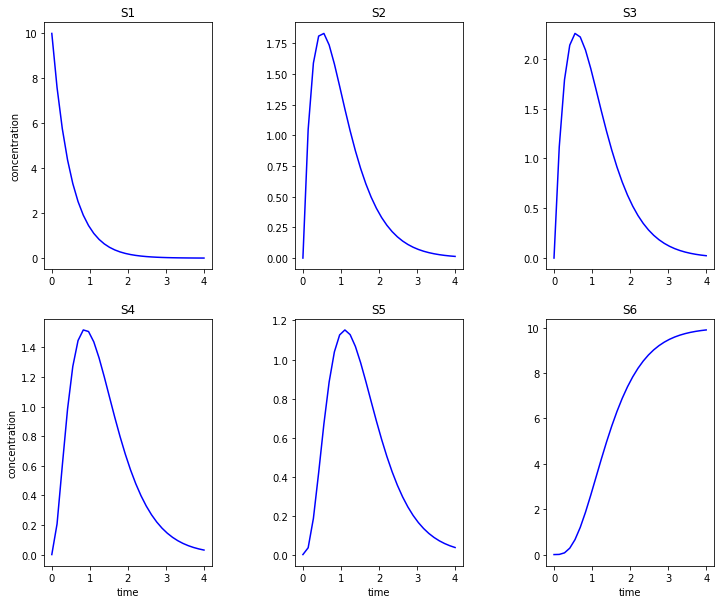

In [14]:
bad_model2 = '''
        # Reactions   
        J1: S1 -> S2; k1*S1
        J1a: S1 -> S3; k1*S1
        J2: S2 -> S3; k2*S2
        J3: S3 -> S4; k3*S3
        J4: S4 -> S5; k4*S4
        J5: S5 -> S6; k5*S5;
        # Species initializations     
        S1 = 10;
        k1 = 1; k2 = 2; k3 = 3; k4 = 4; k5 = 5;
        S1 = 10; S2 = 0; S3 = 0; S4 = 0; S5 = 0; S6 = 0;
        '''
ts2 = runModel(bad_model2)

Do our tests catch this error?

In [15]:
print("Bad model 2, S1 is decreasing. %r." % isDecreasing(ts2["S1"]))
print("Bad model 2, S6 is increasing. %r." % isIncreasing(ts2["S6"]))
checkNonMontone(bad_model2)

Bad model 2, S1 is decreasing. True.
Bad model 2, S6 is increasing. True.
Ok.


We need another tests.

Recall that one expectation for this linear pathway is that the interior species peak at progressively later times. If you look closely, you see that S5 peeks *before* S4.

In [16]:
def reportPeaks(timeseries):
    for colname in timeseries.colnames:
        print("%s: %2.2f" % (colname, getTimeOfPeak(timeseries, colname)))

In [17]:
def getTimeOfPeak(ts, colname):
    """
    Finds the time at which the maximum value occurs
    
    Parameters
    ----------
    ts: NamedTimeseries
    colname: str
        name of column in ts
    """
    return ts.getTimesForValue(colname, max(ts[colname]))[0]

In [18]:
reportPeaks(ts0)

S1: 0.00
S2: 0.69
S3: 1.10
S4: 1.38
S5: 1.66
S6: 4.00


In [19]:
reportPeaks(ts2)

S1: 0.00
S2: 0.55
S3: 0.55
S4: 0.83
S5: 1.10
S6: 4.00


## Breakout

In the following, you will write tests codes for a linear pathway that check for:1. S1 is monotone decreasing
1. S6 is monotone increasing
1. S2-S5 are not monotone.
1. The time at which $S_i$ peaks is less than the time at which $S_{i+1}$ peaks.

You can assume that the pathway starts with S1, and successive integers indicate the step in the pathway.

In [20]:
# TestContainer from Part 1

class TestContainer(object):
    
    def __init__(self, model):
        ts = self._runSimulation(model)
        self.ts = ts
    
    def test1(self):
        if len(self.ts) > 0:
            return True
        else:
            print("No data produced by simulation.")
            return False

    def test2(self):
        s1 = self.ts["S1"]
        if s1[0] == 10:
            return True
        else:
            print("Initial value of S1 should be 10!")
            return False
        
    def test3(self):
        """
        Check that the maximum value of S1 is at time 0.
        """
        s1 = self.ts["S1"]
        if s1[0] == max(s1):
            return True
        else:
            print("The initial value of S1 should be 0!")
            return False
    
    def test4(self):
        """
        Check that the maximum value of s6 is at the end of the simulation.
        """
        s6 = self.ts["S6"]
        if s6[-1] == max(s6):
            return True
        else:
            print("The maximum value of S6 should be at the last time!")
            return False
        
        # Simulation runner
    def _runSimulation(self, model):
        """
        Runs a simulation for an antimony model

        Parameters
        ----------
        model: str

        Returns
        -------
        NamedTimeseries
        """
        rr = te.loada(model)
        data = rr.simulate()
        return NamedTimeseries(named_array=data)
        
    def run(self):
        is_ok = True
        for item in dir(self):
            if item[0:4] == "test":
                # Construct the function call
                func = "self.%s()" % item
                is_ok = is_ok and eval(func)
        if is_ok:
            print("OK.")
        else:
            print("Problems encountered in model.")

In [21]:
tester = TestContainer(true_model)
tester.run()

OK.


#### Create new tests in TestContainer.
   1. The first species is monotone decreasing.
   1. The last species is monotone increasing.
   1. Interior species are not monotone.

In [22]:
def getLastNode(ts):
    """
    Returns the name of the last node in a linear pathway.
    """
    last_stage = max([int(s[1:]) for s in ts.colnames])
    return "S%d" % last_stage

# Add to TestContainer
class TestContainer1(TestContainer):

    def testFirstSpecies(self):
        """
        Checks that the first species is decreasing in concentration.
        """
        s1 = self.ts["S1"]
        if not isDecreasing(s1):
            print("First species must be decreasing!")
            return False
        return True

    def testLastSpecies(self):
        """
        Checks that the last species is increasing in concentration.
        """
        ts = self.ts[getLastNode(self.ts)]
        if not isIncreasing(ts):
            print("Last species must be increasing!")
            return False
        return True

    def testInteriorSpecies(self):
        """
        Does tests on interior nodes.
        """
        last_node = getLastNode(self.ts)
        nodes = [c for c in self.ts.colnames if not c in ["S1", last_node]]
        for node in nodes:
            if isMonotone(self.ts[node]):
                print("Interior node %s should not be monotone." % node)
                return False
        # Compare peak times
        return True

#### Run the tests for true_model and bad_model2

In [23]:
for model in ["true_model", "bad_model1", "bad_model2"]:
    print("*** Testing %s" % model)
    tester = TestContainer1(eval(model))  # Change from the name of the model to the model itself
    tester.run()

*** Testing true_model
OK.
*** Testing bad_model1
Interior node S3 should not be monotone.
Problems encountered in model.
*** Testing bad_model2
OK.
